In [ ]:
from qutip import *
from scipy.optimize import fsolve, leastsq, root, brentq, newton, curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
import scipy as sc
import scipy
from scipy.integrate import dblquad, quad
from scipy.special import laguerre
from time import time

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
        {"font.family": "STIXGeneral",
         "xtick.labelsize": 12,
         "xtick.direction": "in",
         "xtick.major.pad": 3,
         "xtick.top": True,
         "ytick.labelsize": 12,
         "ytick.direction": "in",
         "ytick.right": True,
         "axes.labelsize": 12,
         "axes.labelpad": 3,
         "axes.grid": True
    }
)

# File loading function
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScan'):
    file_path = data_path + date + index + f"/0000{number}-" + exp + ".h5"
    file_path = data_path
    with h5.File(file_path) as file:
        datasets_keys = list(file['datasets'].keys())
    print(datasets_keys)
    with h5.File(file_path, "r") as file:
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)
n_samples = 50

# For shuttled data
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240315/results/"
date = "2024-10-27/"
index = "20"
number = 30524

# File loading
path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
# data_path = path + "2024-10-27/19/000030462-RabiTimeScan.h5"
data_path = path + "2024-10-27/20/000030524-RabiTimeScan.h5"
rabi_t, pmt_counts_avg_thresholded,times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)
indices_to_remove = [9]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to keep
keep_indices[indices_to_remove] = False  # Set indices to remove to False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / ((np.max(pmt_counts_avg_thresholded)))    # / 1.07 - 0.08    # / 0.58 - 0.28

# Running simulation
rabi = 0.031367640379929514*3.14/2
n_ions = 9
N = 200
nbar = 11.8#23.73
nalpha = 30

# rabi =  0.10006110775107444
# nbar =  8.300146520459053
# nalpha =  14.014170204835581

def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, nalpha_fit = nalpha):
    ndisplace_fit = complex(0, np.sqrt(nalpha_fit))
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9
# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

: 

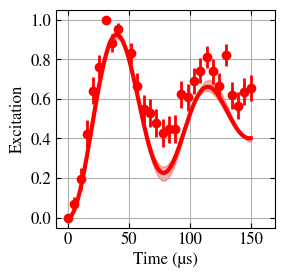

In [2]:
rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [10]:
from qutip import *
from scipy.optimize import curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
from scipy.special import laguerre
from scipy.integrate import dblquad, quad
import scipy

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
    {"font.family": "STIXGeneral",
     "xtick.labelsize": 12,
     "xtick.direction": "in",
     "xtick.major.pad": 3,
     "xtick.top": True,
     "ytick.labelsize": 12,
     "ytick.direction": "in",
     "ytick.right": True,
     "axes.labelsize": 12,
     "axes.labelpad": 3,
     "axes.grid": True
    }
)

# File loading function
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScan'):
    # Construct full file path
    file_path = data_path + date + index + f"/0000{number}-" + exp + ".h5"
    # For debugging or direct file usage, you can hardcode file_path if needed.
    # file_path = data_path  # If you directly used a fixed path
    
    with h5.File(file_path, "r") as file:
        datasets_keys = list(file['datasets'].keys())
        print("Datasets available:", datasets_keys)
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
        
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)


###########################################
# Load and preprocess the data
###########################################

n_samples = 50

# Specify the data path and file details
data_path = "C:/Users/bingr/OneDrive/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
# index = "19"
index = "20"
# number = 30462
number = 30524

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded)

###########################################
# Define the model and fit parameters
###########################################

n_ions = 9
N = 200

def pe_model_optimized_fitting(time, rabi_0_fit, nbar_fit, nalpha_fit):
    ndisplace_fit = complex(0, np.sqrt(nalpha_fit))
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = 0
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9

# Wrapper for curve_fit
def fit_model(time, rabi_0_fit, nbar_fit, nalpha_fit):
    return pe_model_optimized_fitting(time, rabi_0_fit, nbar_fit, nalpha_fit)

# Initial guesses
initial_guess = [0.031367640379929514 * 1.5, 23.73, 0.0]  # [rabi, nbar, nalpha]
bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


Fitted parameters:
rabi =  0.04686170532766234
nbar =  54.818487726129014
nalpha =  3.0361895110951953e-27


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


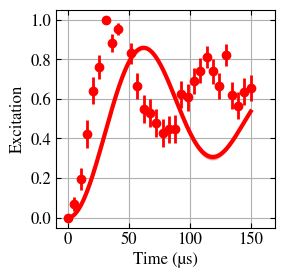

In [10]:
# Running simulation
# rabi =  fitted_rabi
rabi = 0.031367640379929514 * 10
nbar =  fitted_nbar
n_ions = 9
N = 200
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

/var/folders/73/s1xpd2ts0712_vwy8r1jbjyc0000gn/T/ipykernel_14850/2879868478.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


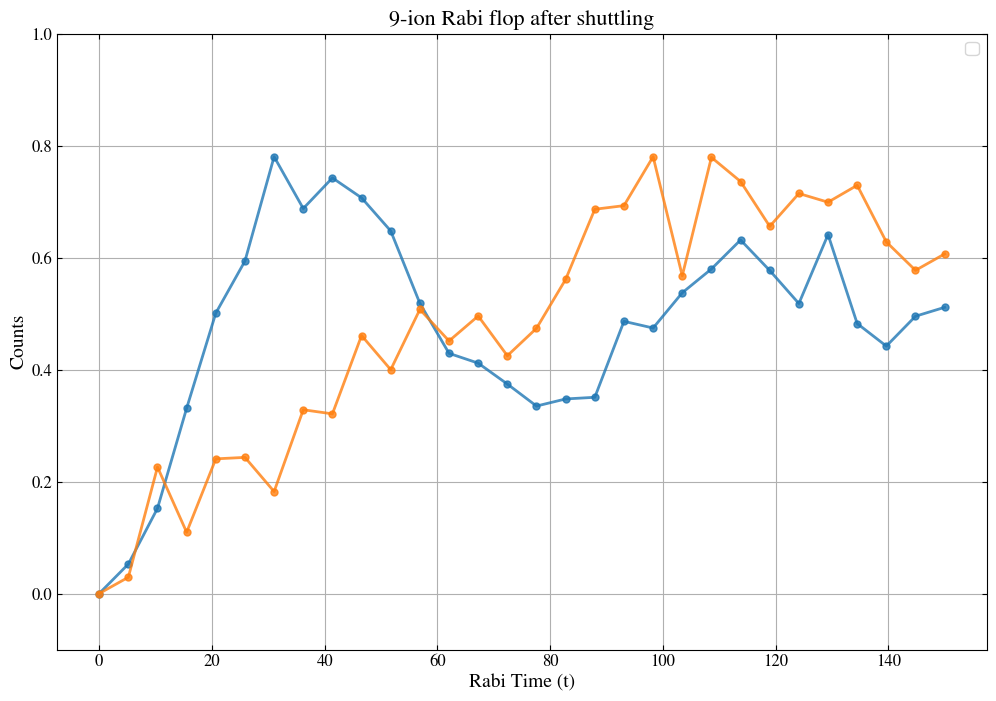

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Load the relevant datasets for analysis
path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/2024-10-27/"
file_path = path + "20/000030524-RabiTimeScan.h5"

data_path_array = ["20/000030524-RabiTimeScan.h5", "20/000030528-RabiTimeScan.h5"]
label_array = ["", ""]

# Plot the results
plt.figure(figsize=(12, 8))

for data_path, label in zip(data_path_array, label_array):
    file_path = path + data_path
    with h5py.File(file_path, 'r') as h5_file:
        rabi_t = h5_file['datasets/rabi_t'][:]
        pmt_counts = h5_file['datasets/pmt_counts'][:]
        fit_signal = h5_file['datasets/fit_signal'][:]
        pmt_counts_avg_thresholded = h5_file['datasets/pmt_counts_avg_thresholded'][:]
        pmt_counts_avg_thresholded_copy = h5_file['datasets/pmt_counts_avg_thresholded'][:]

        # Convert the datasets to numpy arrays
        rabi_t = np.array(rabi_t)
        pmt_counts = np.array(pmt_counts)
        fit_signal = np.array(fit_signal)
        pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)
        pmt_counts_avg_thresholded_copy = np.array(pmt_counts_avg_thresholded_copy)

        # Re-scale it to the range [0, 1] and flip it to start from zero
        pmt_counts_avg_thresholded = pmt_counts_avg_thresholded - np.min(pmt_counts_avg_thresholded)
        pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded)
        pmt_counts_avg_thresholded = 1 - pmt_counts_avg_thresholded

        # Re-scale the fit signal as the PMT counts
        fit_signal = fit_signal - np.min(pmt_counts_avg_thresholded_copy)
        fit_signal = fit_signal / np.max(pmt_counts_avg_thresholded_copy)
        fit_signal = 1 - fit_signal

        # Re-scale the PMT counts as the fit signal
        pmt_counts_avg_thresholded = pmt_counts_avg_thresholded * 0.78
        fit_signal = fit_signal * (0.5 / np.mean(fit_signal))

    # Calculate the mean and standard deviation of PMT counts for visualization
    pmt_counts_mean = np.mean(pmt_counts, axis=1)
    pmt_counts_std = np.std(pmt_counts, axis=1)

    # # Plot PMT counts (mean and standard deviation)
    # plt.errorbar(rabi_t, pmt_counts_mean, yerr=pmt_counts_std, fmt='o', label='PMT Counts (Mean ± Std)', capsize=5)

    # # Plot fit signal
    # plt.plot(rabi_t, fit_signal, label='Fit Signal', linestyle='--', color='red')

    # Plot thresholded average PMT counts
    plt.plot(rabi_t, pmt_counts_avg_thresholded, label=label, linestyle='-', marker='o', markersize=5, linewidth=2, alpha=0.8)

# Add labels, legend, and grid
plt.ylim(-0.1, 1.0)
plt.xlabel('Rabi Time (t)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('9-ion Rabi flop after shuttling', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()